# Spectral Mesh Flattening

by Ana + Gabrielle

In [19]:
import trimesh
import numpy as np
import scipy
from PIL import Image

In [20]:
def boundary(mesh):
    
    """ A function to find the boundary edges and vertices of a mesh. 
        Inputs:
        mesh: a trimesh mesh. 
        Outputs: 
        boundary_vertices: a list of the indices of vertices on the boundary. 
        next_vertex: a dictionary to find the next vertex on the boundary. 
    """

    next_vertex = {}
    boundary_vertices = []

    edges = mesh.edges
    vertex_faces = mesh.vertex_faces
    
    for i in range(len(edges)):

        edge = edges[i]
        v1, v2 = edge
        faces = [j for j in vertex_faces[v1] if j != -1 and j in vertex_faces[v2]]
        
        # Boundary edges are edges that are only in one face
        if len(faces) == 1:

            next_vertex[v1] = v2
            boundary_vertices = boundary_vertices + [v1, v2]
    
    # Remove any duplicates
    boundary_vertices = np.unique(np.array(boundary_vertices))
    
    return boundary_vertices, next_vertex

In [3]:
## This is to export the boundaries coloured. 
# face = trimesh.load("Face.obj")
# b_verts, next_vertex = boundary(face)
# face.visual.vertex_colors[b_verts] = [255, 0, 0, 1]
# face.visual.vertex_colors[1] = [0, 255, 0, 1]
# face.visual.vertex_colors[3] = [0, 0, 255, 1]
# face.export("boundaries.obj")

In [91]:
def circle_boundary(mesh, centre = [0, 0]):

    """ A function to map the boundary of a mesh to a circle centered at the origin. 
        Inputs:
        mesh: a trimesh mesh. 
        centre: optional argument to change the centre of the circle. 
        
        Outputs: 
        new_boundary_values: an array of boundary values (2 dimensional) on the circle. 
    """

    vertices = mesh.vertices

    range_x = (np.max(vertices[:, 0]) - np.min(vertices[:, 0]))/2
    range_y = (np.max(vertices[:, 1]) - np.min(vertices[:, 1]))/2
    range_z = (np.max(vertices[:, 2]) - np.min(vertices[:, 2]))/2

    # Keep the circle roughly the same size as the mesh by choosing half the maximum range
    # as the radius 
    radius = np.max([range_x, range_y, range_z])

    # find the boundary information, and intialize the output 
    b_verts, next_vertex = boundary(mesh)
    output = np.zeros((len(vertices), 2))
    weights = {}
    
    # Calculate the "weights" of each edge and store in a dictionary 
    # to be used to determine how far from the other vertices each edge 
    for i in range(len(b_verts)):
        weights[b_verts[i]] = np.linalg.norm(vertices[b_verts[i]] - vertices[next_vertex[b_verts[i]]])
    
    total = sum(weights.values(), 0.0)
    weights = {k: v / total for k, v in weights.items()}

    # Start with one point set at 0 degrees, and then increase the angle each time (since arc length is
    # proportional to angle)
    angle_sum = 0
    v1 = b_verts[0]
    output[v1] = [centre[0] + radius * np.cos(angle_sum), centre[1] + radius * np.sin(angle_sum)]

    for i in range(len(b_verts)):
        
        angle = weights[v1] * 2 * np.pi
        angle_sum += angle

        # calculate the new positions
        new_x = centre[0] + radius * np.cos(angle_sum)
        new_y = centre[1] + radius * np.sin(angle_sum)

        v1 = next_vertex[v1]
        output[v1] = [new_x, new_y]

    # make sure the outputs are in the same order as the b_verts 
    new_boundary_values = output[b_verts]

    return new_boundary_values

'# https://github.com/mikedh/trimesh\nv 3.50539990 -29.80739970 -6.45559980\nv 3.42230010 -29.84149930 -6.42889980\nv 3.41339990 -29.87360000 -6.53039980\nv 3.52819990 -29.81600000 -6.53170010\nv 3.31060000 -29.91259960 -6.38340000\nv 3.29169990 -29.95310020 -6.49800010\nv 3.29080010 -30.00320050 -6.61399980\nv 3.42540000 -29.91349980 -6.63719990\nv 3.55640010 -29.84580040 -6.63130000\nv 3.09859990 -30.16900060 -6.25400020\nv 3.06820010 -30.21279910 -6.38100000\nv 3.17190000 -30.06609920 -6.44610020\nv 3.19680000 -30.02230070 -6.32340000\nv 3.16230010 -30.11969950 -6.56899980\nv 3.05139990 -30.26609990 -6.50799990\nv 3.17590000 -30.25530050 -6.82079980\nv 3.16479990 -30.18280030 -6.69339990\nv 3.04570010 -30.32819940 -6.63670020\nv 3.04889990 -30.39830020 -6.76809980\nv 3.31859990 -30.13730050 -6.85440020\nv 3.30090000 -30.06469920 -6.73239990\nv 3.61400010 -29.96800040 -6.85069990\nv 3.58470010 -29.89830020 -6.73810010\nv 3.44420000 -29.97069930 -6.74889990\nv 3.46760010 -30.04220010 

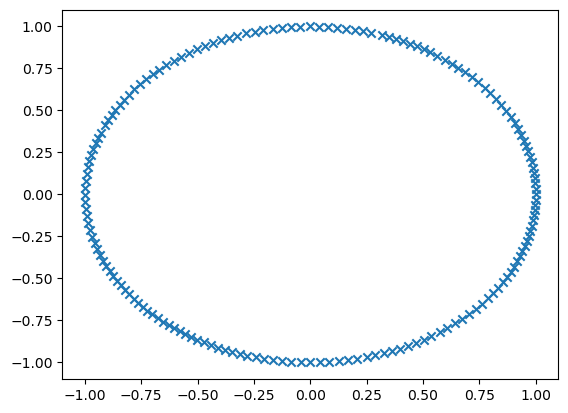

In [86]:
# This cell exports the mesh with the boundary vertices transformed to the 2d circle. 
import matplotlib.pyplot as plt
%matplotlib inline

face = trimesh.load("Horse.obj")
xy = np.array(circle_boundary(face))
x = xy[:, 0]
y = xy[:, 1]
plt.scatter(x, y, marker = 'x')
b_verts, _ = boundary(face)
face.vertices[b_verts] = np.hstack((xy, -12*np.ones((len(x), 1))))
face.export("CircleExperiment.obj")

In [87]:
def angle(v0, v1, v2):

    """ A function to work out the angle between two edges. 
        Inputs:
        v0: vertex coordinates at the centre of the edges
        v1: vertex of edge1
        v2: vertex of edge2
        
        returns: angle between edge from v0 to v1 and edge from v0 to v2
    """

    edge1 = v1 - v0
    edge2 = v2 - v0

    return np.arccos(np.clip(np.dot(edge1, edge2)/(np.linalg.norm(edge1)*np.linalg.norm(edge2)), -1, 1))

def LaplaceBeltrami(mesh, return_full = True):

    """ A function to find the cotangent discretization of the Laplacian. 
        Inputs:
        mesh: a trimesh mesh
        return_full: an optional argument to toggle whether you want L or M^-1 and C returned
        Outputs:
        L: the cotangent discretization of the Laplacian. 
        M_inv: the inverse of the normalization matrix (1/2Ai for each diagonal element)
        C: the cotan matrix
    """

    vs = mesh.vertices
    fs = mesh.faces
    vert_ns = mesh.vertex_neighbors
    vert_fs = mesh.vertex_faces

    n = len(vs)
    #areas = voronoi_area(mesh)
    areas = np.zeros(n)
    #M_inv = scipy.sparse.diags(1/(2*areas))
    C = scipy.sparse.lil_matrix(np.zeros((n, n)))
    
    for vertex in range(len(mesh.vertices)):
        # for every vertex find the neighbours and the faces 
        faces = vert_fs[vertex][vert_fs[vertex] != -1]

        for neighbour in vert_ns[vertex]:
            # for every neighbour find the faces that are shared with the vertex, and the other vertices on those faces
            faces = [i for i in vert_fs[vertex] if neighbour in fs[i] and i != -1] 
            vertices = [i for i in fs[faces].flatten() if not i in [vertex, neighbour, -1]]

            if len(vertices) > 1:

                angle1 = angle(vs[vertices[0]], vs[vertex], vs[neighbour])
                angle2 = angle(vs[vertices[1]], vs[vertex], vs[neighbour])
            
            # This is the case where the mesh is not closed
            else:
                angle1 = angle(vs[vertices[0]], vs[vertex], vs[neighbour])
                angle2 = angle1

            # account for division by zero (and near zero)
            if abs(np.tan(angle1)) < 1e-10:
                cot_alpha = 1e10
            else:
                cot_alpha = 1/np.tan(angle1)

            if abs(np.tan(angle2)) < 1e-10:
                cot_beta = 1e10
            else:
                cot_beta = 1/np.tan(angle2)
            
            # Assign the values 
            C[vertex, neighbour] = cot_alpha + cot_beta
            C[vertex, vertex] -= cot_alpha + cot_beta 

            # voronoi areas 
            areas[vertex] += (C[vertex, neighbour] * np.linalg.norm(vs[vertex] - vs[neighbour])**2) / 8

    M_inv = scipy.sparse.diags(1/(2*areas))
    
    if return_full:
        L = (M_inv @ C)
        return L.tocsr()

    else:
        return M_inv.tocsc(), C.tocsc()

In [92]:
def tutte_embedding(mesh, boundary_function = circle_boundary):

    """ A function that uses Tutte's embedding method to flatten a mesh
        with given boundary conditions. 
        Inputs: 
        mesh: a trimesh mesh. 
        boundary_function: a function that returns the 2D coordinates for the boundary vertices.
         
        Outputs: 
        flat_mesh: the flattened mesh. 
    """

    flat_mesh = mesh.copy()

    vertices = mesh.vertices
    b_verts, _ = boundary(mesh)
    b_vals = boundary_function(mesh)
    _, C = LaplaceBeltrami(mesh, return_full = False)
    C = C.tolil()
    
    for vert in b_verts:
        C[vert, :] = np.zeros(C.shape[1])
        C[vert, vert] = 1
    
    C = C.tocsc()
    
    B = np.zeros((len(vertices), 2))
    B[b_verts] = b_vals

    X = scipy.sparse.linalg.spsolve(C, B)
    flat_mesh.vertices = np.hstack((X, np.zeros((X.shape[0], 1))))

    return flat_mesh

In [95]:
def export_textured(mesh_filename, export_name, flat_export_name, texture_name = 'CheckTexture.png'):

    """ A function to export a mesh and a flattened mesh with a texture using the 
        flat mesh as the UV parametrization. 
        Inputs:
        mesh_filename: mesh to import. 
        export_name: name that the original mesh (with texture) will be saved to. 
        flat_export_name: flattened textured mesh export name. 
        texture_name: optional argument to determine which texture to apply. 
    """

    mesh = trimesh.load(mesh_filename)
    flat_mesh = tutte_embedding(mesh)

    uv_coordinates = flat_mesh.vertices[:, :2]
    texture = Image.open(texture_name)

    mesh.visual = trimesh.visual.TextureVisuals(uv=uv_coordinates)
    flat_mesh.visual = trimesh.visual.TextureVisuals(uv=uv_coordinates)

    mesh.visual.material.image = texture
    flat_mesh.visual.material.image = texture

    mesh.export(export_name, include_texture=True)
    flat_mesh.export(flat_export_name, include_texture=True)

    return 

export_textured("EasterHead.obj", "texHead.obj", "texFlatHead.obj")